In [1]:
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import json

## Synthetic ts

In [47]:
def generate_ARHT(t_0, T, num_harmonics = 0, coeffs = None, periods = None, max_period = 100, min_period = 0,
                  trend = False, power = 0, const = 0, var = 1):
    signal = np.zeros(T - t_0 + 1)
    t = np.arange(t_0,T+1)
    alpha = 10/(T - t_0)
    if num_harmonics: #todo: Check consistant number of harmonics length of coeffs and periods
        if coeffs is None:
            coeffs = 2 * np.random.random(harmonics_components) + 0.3
        if periods is None:
            sine_periods = ((max_period-min_period)* np.random.random(num_harmonics) + min_period)
        for i in range(num_harmonics): 
            signal += coeffs[i] * np.sin((t/(T - t_0 + 1))*periods[i]*2.0*np.pi)
    if trend: #add more trend types
        signal += alpha*t**power
    if const: 
        signal += const
    noise = np.random.normal(0.0, np.sqrt(var), T - t_0 + 1)
    noisy_ts = signal + noise
    return noisy_ts, signal



In [61]:
def generate_synthetic(cp_type, cp_number, T, nh, trend, noise_var, power = 0): 
    ts = np.array([])
    tm = np.array([])
    if cp_type == 'multi': 
        const = np.zeros(cp_number)
        coeffs = np.tile(np.random.random(nh)*7, cp_number).reshape(cp_number,nh)
        periods = np.zeros((cp_number, nh))
        for i in range(cp_number): 
            if i%2==0: 
                periods[i, :] = 5 + np.random.random(nh) * 30
            else: 
                periods[i, :] = 5 + np.random.random(nh) * 70
    if cp_type == 'mean': 
        const = np.random.random(cp_number) * 10
        coeffs = np.tile(np.random.random(nh)*7, cp_number).reshape(cp_number,nh)
        periods = np.tile(5+np.random.random((nh))*100, cp_number).reshape(cp_number,nh)
    if cp_type == 'energy': 
        const = np.zeros(cp_number)
        periods = np.tile(5+np.random.random((nh))*100, cp_number).reshape(cp_number,nh)
        coeffs = np.zeros((cp_number, nh))
        for i in range(cp_number): 
            if i%2==0: 
                coeffs[i, :] = np.random.random() * 7 * np.ones(nh)
            else: 
                coeffs[i, :] = np.random.random() * 5 * np.ones(nh)
    param = {}
    for i in range(0, cp_number):
        key = 'ts_{}'.format(i)
        param[key] = {'periods': periods[i], 'coeffs': coeffs[i], 'conts': const[i], 'noice': noise_var, 'trend_power': power}
        ts_, tm_ = generate_ARHT(i*T + 1, (i+1)*T, num_harmonics = nh, coeffs = coeffs[i], periods = periods[i], 
                                 max_period = 100, min_period = 0, trend = trend, power = power, const = const[i], var = noise_var)
        ts = np.append(ts, ts_)
        tm = np.append(tm, tm_)
    start = np.arange(0, cp_number) * T
    end = np.arange(1, cp_number+1) * T - 1
    new_labels = pd.DataFrame(start)
    new_labels[1] = end
    return ts, tm, new_labels, param

        
        
        
        
        

In [62]:
def json_converter(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, datetime.datetime):
            return obj.__str__()

In [89]:
cp_type = 'multi'
cp_number = 5 
T = 200
nh = 5 
trend = True
noise_var = 0.00
samples = 5
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data', cp_type)
no_fundemental_ts = 10
no_ts = 100
var = 49
fund_ts = np.zeros([no_fundemental_ts, T*cp_number])
for sample in range(samples):
    all_param = {}
    for i in range(no_fundemental_ts):
        ts, tm, labels, param = generate_synthetic(cp_type, cp_number, T, nh, trend, noise_var, power = 1)
        fund_ts[i,:] = tm
        all_param['fundemental_ts_%d'%i]= param
    U = np.random.randn(no_ts,no_fundemental_ts)
    tm = np.dot(U, fund_ts).T
    noise = np.random.normal(0.0, np.sqrt(var), [T*cp_number, no_ts])
    ts = tm + noise 
    df = pd.DataFrame(ts)
    df.reset_index(inplace=True)
    df.to_csv(path_or_buf=os.path.join(data_path, '{}{}_ts.csv'.format(cp_type, sample)), index=False, header=False)
    df = pd.DataFrame(tm)
    df.reset_index(inplace=True)
    df.to_csv(path_or_buf=os.path.join(data_path, '{}{}_tm.csv'.format(cp_type, sample)), index=False, header=False)
    labels.to_csv(path_or_buf=os.path.join(data_path, '{}{}_labels.csv'.format(cp_type, sample)), index=False, header=False)
    with open(os.path.join(data_path, '{}{}_param.json'.format(cp_type, sample)), 'w') as file:
        json.dump(all_param, file, default=json_converter)
    

In [88]:
np.linalg.matrix_rank(ts)

100

In [82]:
ts1, tm1 = generate_ARHT(0, 2000, num_harmonics = 3, coeffs = [2,4,3], periods = [60, 20,30], max_period = 100, min_period = 0,
                  trend = False, power = 0, const = 0, var = 0.5)

ts2, tm2 = generate_ARHT(0, 2000, num_harmonics = 3, coeffs = [4,5,3], periods = [80, 20,30], max_period = 100, min_period = 0,
                  trend = False, power = 0, const = 0, var = 0.5)

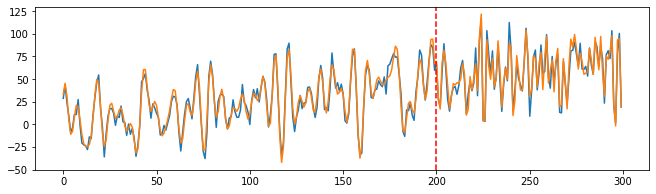

In [83]:
plt.figure(figsize=(11,3))
plt.plot(ts[1,:300])
plt.plot(tm[1,:300])
plt.axvline(labels[0][1], color="r", linestyle = "--")
plt.savefig("1.png", dpi=400)

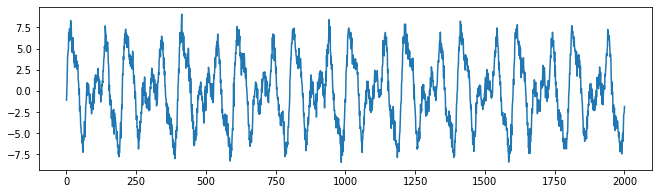

In [57]:
plt.figure(figsize=(11,3))
plt.plot(ts1)
plt.savefig("2.png", dpi=400)

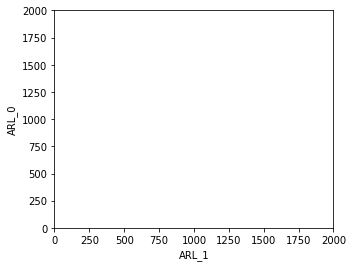

In [69]:
plt.figure(figsize=(5,4))
plt.axis([0, 2000, 0,2000])
plt.xlabel("ARL_1")
plt.ylabel("ARL_0")

plt.savefig("2.png", dpi=400)


In [37]:
np.append(ts, tm)

array([-0.77346132, -0.05652437,  3.78625685, ..., -2.65689769,
       -1.79884881, -0.90779855])

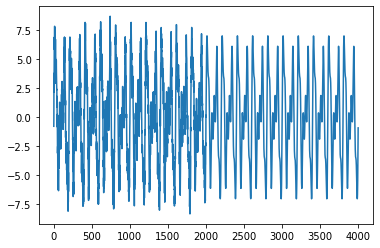

In [38]:
plt.plot(np.append(ts, tm))